In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import json
import numpy as np
from operator import itemgetter
import os
import pickle as pkl
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

np.seterr(divide='ignore') # masks log(0) errors

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir("drive/My Drive/Colab Notebooks")

Mounted at /content/drive


In [4]:
from hybrid.hmm.multiple import FullGaussianHMM

The default DNN set-up should take ~40 seconds/epoch on a GPU (and ~350 secconds/epoch on a CPU).

Performance (WER) on test set:   

Baseline performance of the GMM-HMM model   
24.55%

Performance of the DNN-HMM model with normalized emission probabilities   
20.45%

Performance of the DNN-HMM model with unnormalized emission probabilities   
18.18%

## Training a multiple digit GMM-HMM model
NOTE: You are not expected to run/tune this part as the trained FullGaussianHMM model file is provided. The provided model is designed to have 15 states for each digit and 3 additional states for start, pause, and end. Feel free to look through hybrid/hmm/multiple.py to see how we can string single-digit HMMs to obtain the one that can model multiple-digit sequences.

In [15]:
# """
# Multiple Digit HMM: training two-digit sequences
# """
# data_multiple_digit = np.load("hybrid/data/mfccs/mfccs_multiple.npz", allow_pickle=True)
# full_model = FullGaussianHMM(data_multiple_digit["Xtrain"], "hybrid/hmm/models/single_digit_model.pkl")

# n_iter = 15

# print("Training HMM")
# for i in range(n_iter):
#     print("starting iteration {}...".format(i + 1))
#     full_model.train(data_multiple_digit["Xtrain"], data_multiple_digit["Ytrain"])
        
# print("Testing HMM")
# test_wer = full_model.test(data_multiple_digit["Xtest"], data_multiple_digit["Ytest"])
# print("{:.2f}% WER".format(test_wer * 100.))

# with open("hybrid/hmm/models/multiple_digit_model.pkl", "wb") as f:
#     pkl.dump(full_model, f)

## Saving the optimal state sequences
Save the optimal state label per framee using the trained GMM-HMM model. Complete the # TODO in force_align function

In [18]:
def force_align(X, Y, hmm_gmm_model):
    """
    Force align using Viterbi to get the hidden state sequence for each (X, Y) pair.
    ------
    input:
    X: list of 2d-arrays of shape (Tx, 13): list of single digit MFCC features
    Y: digit sequence
    hmm_gmm_model: load the trained model
    ------
    Returns a list of utterence-wise hidden state sequences
    """
    digit_states_total, start_states = hmm_gmm_model.digit_states_total, hmm_gmm_model.start_states
    begin_sil_id, pause_id, end_sil_id = hmm_gmm_model.begin_sil, hmm_gmm_model.pause, hmm_gmm_model.end_sil
    A_estimate, pi_estimate = hmm_gmm_model.A, hmm_gmm_model.pi
    state_seqs = []
    for ii, (x, y) in enumerate(zip(X, Y)):

        y = np.array([0 if yy == 'o' else int(yy) for yy in y], dtype=np.int32)

        # TODO: edit A_estimate appropriately to enable decoding for the ground-truth labelss
        y1, y2 = y
        stop_states = hmm_gmm_model.stop_states

        # begin silence to the start state in first digit
        temp = A_estimate[begin_sil_id,begin_sil_id]
        A_estimate[begin_sil_id,:] = 0
        A_estimate[begin_sil_id,begin_sil_id] = temp
        A_estimate[begin_sil_id,start_states[y1]] = 1-temp
        
        # stop state in first digit to pause
        temp = A_estimate[stop_states[y1],stop_states[y1]]
        A_estimate[stop_states[y1],:] = 0
        A_estimate[stop_states[y1],stop_states[y1]] = temp
        A_estimate[stop_states[y1],pause_id] = 1-temp
        
        # pause to the start state in second digit
        temp = A_estimate[pause_id,pause_id]
        A_estimate[pause_id,:] = 0
        A_estimate[pause_id,pause_id] = temp
        A_estimate[pause_id,start_states[y2]] = 1-temp
        
        # stop state in second digit to sentence final silence
        temp = A_estimate[stop_states[y2],stop_states[y2]]
        A_estimate[stop_states[y2],:] = 0
        A_estimate[stop_states[y2],stop_states[y2]] = temp
        A_estimate[stop_states[y2],end_sil_id] = 1-temp
        
        log_pi = np.log(pi_estimate)
        log_A = np.log(A_estimate)
        log_B = hmm_gmm_model.get_emissions(x)

        q, log_prob = hmm_gmm_model.viterbi(log_pi, log_A, log_B) 
        state_seqs.append(q)

    return state_seqs

In [6]:
data_multiple_digit = np.load("hybrid/data/mfccs/mfccs_multiple.npz", allow_pickle=True)
with open("hybrid/hmm/models/multiple_digit_model.pkl", "rb") as f:
    hmm_gmm_model = pkl.load(f)
    
state_seq_train = force_align(data_multiple_digit["Xtrain"], data_multiple_digit["Ytrain"], hmm_gmm_model)
state_seq_dev = force_align(data_multiple_digit["Xdev"], data_multiple_digit["Ydev"], hmm_gmm_model)
state_seq_test = force_align(data_multiple_digit["Xtest"], data_multiple_digit["Ytest"], hmm_gmm_model)
seqDict = {'Ytrain': state_seq_train, 'Ydev': state_seq_dev, 'Ytest': state_seq_test, 'total_states': hmm_gmm_model.total}
np.savez_compressed('hybrid/data/state_seq/state_seq.npz', **seqDict)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


## Training a DNN frame classifier

In [5]:
from hybrid.dnn.loader import DataLoader

In [6]:
with open("hybrid/dnn/config.json", "r") as fid:                                                                                                                                                                                                                                      
    config = json.load(fid)

np.random.seed(config["seed"])
torch.manual_seed(config["seed"])

data_cfg = config["data"]
model_cfg = config["model"]
opt_cfg = config["optimizer"]
out_cfg = config["output"]

data_mfccs = np.load(data_cfg["mfcc"], allow_pickle=True)
state_seq = np.load(data_cfg["state_seq"], allow_pickle=True)

print("Preparing data...\n")
data_ldr = DataLoader(data_cfg)
train_features, train_labels, train_labels_onehot, train_utt_to_frames = data_ldr.prepare_data('train')
dev_features, dev_labels, dev_labels_onehot, dev_utt_to_frames = data_ldr.prepare_data('dev')
test_features, test_labels, test_labels_onehot, test_utt_to_frames = data_ldr.prepare_data('test')

feat_dim = (data_ldr.context_size+1)*data_ldr.mfcc_dim
n_states = data_ldr.n_states

Preparing data...



In [7]:
class FeedForward(nn.Module):

    def __init__(self, feat_dim, n_states, hidden_dim, n_layers, dropout):
        """
        Initialized feed forward neural network model.
        ---
        feat_dim: input feature dimension
        n_states: size of the output
        hidden_dim: dimension of the hidden layers
        n_layers: number of layers
        dropout: dropout probabilty for the dropout layer
        """
        super().__init__()

        self.n_layers = n_layers
        self.fc_input = nn.Linear(feat_dim, hidden_dim)
        self.fc_output = nn.Linear(hidden_dim, n_states)
        self.fc_hidden_list = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim)]*n_layers)
        self.nl = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        """
        Forward pass for the feedforward network
        """
        x = self.nl(self.fc_input(x))
        for i in range(self.n_layers):
            x = self.nl(self.fc_hidden_list[i](x))
        output = F.leaky_relu(self.fc_output(x))

        return output

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

In [13]:
def train(epoch):
    """
    Training the classifier on frame level labels
    """
    classifier.train()
    perm = np.random.permutation(train_features.shape[0])
    train_loss, pred_multi, gt_multi = [], [], []
    n_iter = 0
    start = time.time()
    time_per_iter = [0]*4
    for i in range(0, len(perm), batch_size):
        idx = perm[i:i+batch_size]
        train_Xs = torch.tensor(train_features[idx], dtype=torch.float32).to(device)
        train_Ys = torch.tensor(train_labels[idx], dtype=torch.long).to(device)
        pred_Ys = classifier(train_Xs)
        loss = loss_function(pred_Ys, train_Ys)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), 5.0)
        optimizer.step()
        train_loss.append(loss.cpu().item())
        pred_multi.append(np.argmax(pred_Ys.cpu().data.numpy(), axis=1))
        gt_multi.append(train_Ys.cpu().data.numpy())
    pred_multi, gt_multi = np.concatenate(pred_multi, axis=0), np.concatenate(gt_multi, axis=0)
    accuracy = 100*len(np.where((pred_multi - gt_multi)==0)[0])/len(pred_multi)
    print("Epoch: %d, Training loss: %.2f, Accuracy: %.2f, Time elapsed: %.2f seconds" % (epoch, np.mean(train_loss), accuracy, time.time() - start))

    return accuracy, np.mean(train_loss)

def test(features, labels, classifier_test=None):
    """
    Training the classifier on frame level labels
    """
    if classifier_test is None:
        classifier_test = torch.load(save_model_fn)
    classifier_test.eval()
    test_loss, pred_multi, gt_multi = [], [], []
    n_iter = 0
    start = time.time()
    for i in range(0, len(features), test_batch_size):
        n_iter += 1
        idx = list(range(i, min(i+test_batch_size, len(features))))
        test_Xs = torch.tensor(features[idx], dtype=torch.float32).to(device)
        test_Ys = torch.tensor(labels[idx], dtype=torch.long).to(device)
        pred_Ys = classifier_test(test_Xs)
        loss = loss_function(pred_Ys, test_Ys)
        test_loss.append(loss.cpu().item())
        pred_multi.append(np.argmax(pred_Ys.cpu().data.numpy(), axis=1))
        gt_multi.append(test_Ys.cpu().data.numpy())

    pred_multi, gt_multi = np.concatenate(pred_multi, axis=0), np.concatenate(gt_multi, axis=0)
    accuracy = 100*len(np.where((pred_multi - gt_multi)==0)[0])/len(pred_multi)

    print("Dev Accuracy: %.2f, Time elapsed: %.2f seconds" % (accuracy, time.time() - start))

    return accuracy

In [21]:
def main_train():
    print("Training begins ...\n")
    best_accuracy = 0
    train_dev = np.zeros((3,tot_epoch)) # 3 rows for train_accuracy, dev accuracy and train_loss
    for epoch in range(tot_epoch):
        train_accuracy, train_loss = train(epoch)
        dev_accuracy = test(dev_features, dev_labels, classifier)
        train_dev[0,epoch] = train_accuracy
        train_dev[1,epoch] = train_loss
        train_dev[2,epoch] = dev_accuracy

        if dev_accuracy > best_accuracy:
            best_epoch = epoch
            torch.save(classifier, save_model_fn)
            best_accuracy = dev_accuracy
    print('\nBest dev accuracy: %.2f at epoch: %d' % (best_accuracy, best_epoch))

    return train_dev

def main_test():
    accuracy = test(test_features, test_labels)
    print('\nAccuracy on test set: %.2sf' % (accuracy))

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.backends.cudnn.deterministic = True

In [25]:
# tot_epoch = opt_cfg["max_epochs"]
# hidden_dim = model_cfg["hidden_dim"]
# n_layers = model_cfg["n_layers"]
# dropout = model_cfg["dropout_probability"]

# batch_size = opt_cfg["batch_size"]
# test_batch_size = opt_cfg["test_batch_size"]
def tunning(tot_epoch = opt_cfg["max_epochs"], hidden_dim = model_cfg["hidden_dim"], n_layers = model_cfg["n_layers"], dropout = model_cfg["dropout_probability"], batch_size = opt_cfg["batch_size"], test_batch_size = opt_cfg["test_batch_size"]):
  save_model_fn = os.path.join(out_cfg["save_dir"], "dnn_model.pkl")
  classifier = FeedForward(feat_dim, n_states, hidden_dim, n_layers, dropout).to(device)
  # classifier.apply(init_weights)
  loss_function = nn.CrossEntropyLoss()
  optimizer = getattr(torch.optim, opt_cfg["type"])(list(classifier.parameters()))

  train_dev = main_train()
  return train_dev


In [26]:
# changing the n_layers
# n_layers = 1 batch_size = 8
train_dev = tunning()

Training begins ...

Epoch: 0, Training loss: 1.27, Accuracy: 62.19, Time elapsed: 70.72 seconds
Dev Accuracy: 52.49, Time elapsed: 1.99 seconds
Epoch: 1, Training loss: 1.17, Accuracy: 64.94, Time elapsed: 70.43 seconds
Dev Accuracy: 51.44, Time elapsed: 2.00 seconds
Epoch: 2, Training loss: 1.10, Accuracy: 66.95, Time elapsed: 70.96 seconds
Dev Accuracy: 51.40, Time elapsed: 2.00 seconds
Epoch: 3, Training loss: 1.04, Accuracy: 68.63, Time elapsed: 70.91 seconds
Dev Accuracy: 51.44, Time elapsed: 1.99 seconds
Epoch: 4, Training loss: 1.00, Accuracy: 69.97, Time elapsed: 70.41 seconds
Dev Accuracy: 51.05, Time elapsed: 1.97 seconds
Epoch: 5, Training loss: 0.96, Accuracy: 71.05, Time elapsed: 70.39 seconds
Dev Accuracy: 50.23, Time elapsed: 1.97 seconds
Epoch: 6, Training loss: 0.93, Accuracy: 71.96, Time elapsed: 71.06 seconds
Dev Accuracy: 50.69, Time elapsed: 1.98 seconds
Epoch: 7, Training loss: 0.90, Accuracy: 72.79, Time elapsed: 70.69 seconds
Dev Accuracy: 49.82, Time elapsed: 

In [28]:
import matplotlib.pyplot as plt

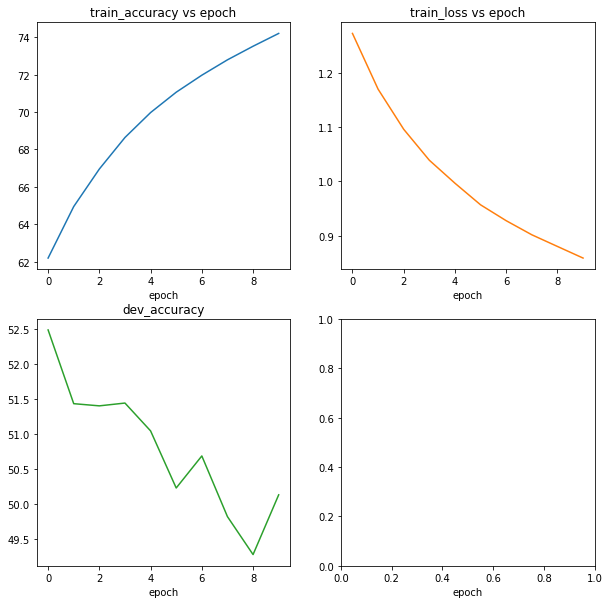

In [53]:
mesh = np.arange(10)

fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].plot(mesh, train_dev[0])
axs[0, 0].set_title('train_accuracy vs epoch')
axs[0, 1].plot(mesh, train_dev[1], 'tab:orange')
axs[0, 1].set_title('train_loss vs epoch')
axs[1, 0].plot(mesh, train_dev[2], 'tab:green')
axs[1, 0].set_title('dev_accuracy')

for ax in axs.flat:
    ax.set(xlabel='epoch')


In [54]:
# changing the n_layers
# n_layers = 2 batch_size = 8
train_dev = tunning(n_layers=2)

Training begins ...

Epoch: 0, Training loss: 0.84, Accuracy: 74.61, Time elapsed: 72.73 seconds
Dev Accuracy: 48.78, Time elapsed: 2.02 seconds
Epoch: 1, Training loss: 0.83, Accuracy: 75.05, Time elapsed: 71.44 seconds
Dev Accuracy: 50.44, Time elapsed: 1.99 seconds
Epoch: 2, Training loss: 0.82, Accuracy: 75.45, Time elapsed: 71.94 seconds
Dev Accuracy: 48.56, Time elapsed: 2.04 seconds
Epoch: 3, Training loss: 0.81, Accuracy: 75.90, Time elapsed: 71.97 seconds
Dev Accuracy: 48.24, Time elapsed: 2.01 seconds
Epoch: 4, Training loss: 0.80, Accuracy: 76.22, Time elapsed: 71.48 seconds
Dev Accuracy: 49.04, Time elapsed: 1.99 seconds
Epoch: 5, Training loss: 0.79, Accuracy: 76.51, Time elapsed: 71.61 seconds
Dev Accuracy: 50.17, Time elapsed: 1.99 seconds
Epoch: 6, Training loss: 0.78, Accuracy: 76.84, Time elapsed: 71.52 seconds
Dev Accuracy: 49.42, Time elapsed: 2.03 seconds
Epoch: 7, Training loss: 0.77, Accuracy: 76.99, Time elapsed: 71.80 seconds
Dev Accuracy: 49.27, Time elapsed: 

n_layers=2 and batch_size=8


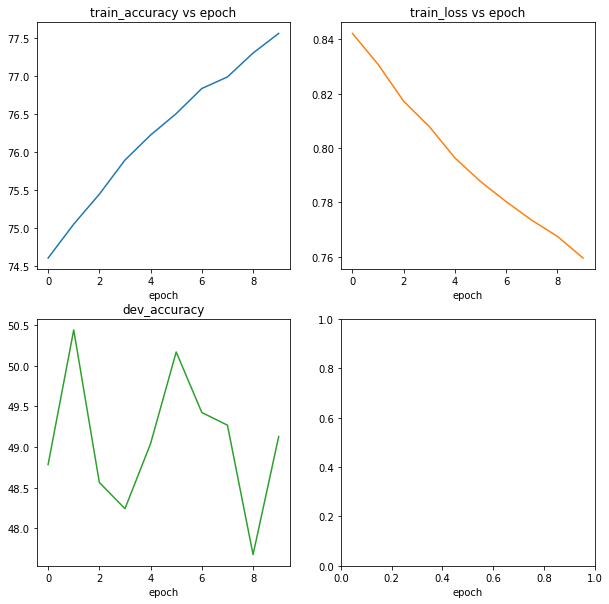

In [55]:
print('n_layers=2 and batch_size=8')
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].plot(mesh, train_dev[0])
axs[0, 0].set_title('train_accuracy vs epoch')
axs[0, 1].plot(mesh, train_dev[1], 'tab:orange')
axs[0, 1].set_title('train_loss vs epoch')
axs[1, 0].plot(mesh, train_dev[2], 'tab:green')
axs[1, 0].set_title('dev_accuracy')

for ax in axs.flat:
    ax.set(xlabel='epoch')

In [56]:
# changing the n_layers
# n_layers = 3 batch_size = 8
train_dev = tunning(n_layers=3)

Training begins ...

Epoch: 0, Training loss: 0.75, Accuracy: 77.62, Time elapsed: 72.98 seconds
Dev Accuracy: 49.95, Time elapsed: 2.03 seconds
Epoch: 1, Training loss: 0.75, Accuracy: 77.90, Time elapsed: 72.47 seconds
Dev Accuracy: 49.68, Time elapsed: 2.02 seconds
Epoch: 2, Training loss: 0.74, Accuracy: 78.15, Time elapsed: 72.78 seconds
Dev Accuracy: 48.75, Time elapsed: 2.03 seconds
Epoch: 3, Training loss: 0.74, Accuracy: 78.20, Time elapsed: 72.90 seconds
Dev Accuracy: 49.28, Time elapsed: 1.96 seconds
Epoch: 4, Training loss: 0.74, Accuracy: 78.28, Time elapsed: 72.91 seconds
Dev Accuracy: 49.88, Time elapsed: 2.02 seconds
Epoch: 5, Training loss: 0.74, Accuracy: 78.54, Time elapsed: 72.83 seconds
Dev Accuracy: 49.09, Time elapsed: 2.01 seconds
Epoch: 6, Training loss: 0.73, Accuracy: 78.58, Time elapsed: 72.39 seconds
Dev Accuracy: 49.33, Time elapsed: 2.04 seconds
Epoch: 7, Training loss: 0.73, Accuracy: 78.74, Time elapsed: 72.63 seconds
Dev Accuracy: 50.01, Time elapsed: 

n_layers=3 and batch_size=8


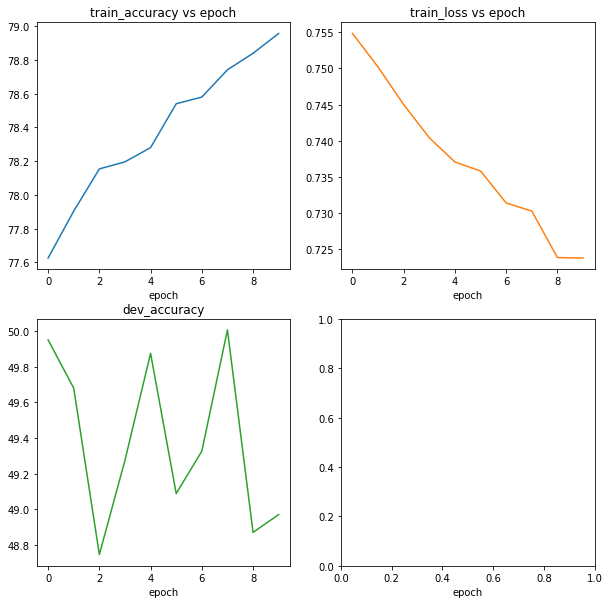

In [57]:
print('n_layers=3 and batch_size=8')
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].plot(mesh, train_dev[0])
axs[0, 0].set_title('train_accuracy vs epoch')
axs[0, 1].plot(mesh, train_dev[1], 'tab:orange')
axs[0, 1].set_title('train_loss vs epoch')
axs[1, 0].plot(mesh, train_dev[2], 'tab:green')
axs[1, 0].set_title('dev_accuracy')

for ax in axs.flat:
    ax.set(xlabel='epoch')

In [ ]:
# the best n_layers is surprisingly 1.
# Now we fixed n_layers=1 and change batch size

In [58]:
# changing the n_layers
# n_layers = 1 batch_size = 16
train_dev = tunning(batch_size=16)

Training begins ...

Epoch: 0, Training loss: 0.72, Accuracy: 79.10, Time elapsed: 73.73 seconds
Dev Accuracy: 48.93, Time elapsed: 2.04 seconds
Epoch: 1, Training loss: 0.72, Accuracy: 79.17, Time elapsed: 71.63 seconds
Dev Accuracy: 49.83, Time elapsed: 2.03 seconds
Epoch: 2, Training loss: 0.71, Accuracy: 79.32, Time elapsed: 71.75 seconds
Dev Accuracy: 49.12, Time elapsed: 1.98 seconds
Epoch: 3, Training loss: 0.72, Accuracy: 79.43, Time elapsed: 71.88 seconds
Dev Accuracy: 49.20, Time elapsed: 1.96 seconds
Epoch: 4, Training loss: 0.71, Accuracy: 79.48, Time elapsed: 71.73 seconds
Dev Accuracy: 49.32, Time elapsed: 2.02 seconds
Epoch: 5, Training loss: 0.71, Accuracy: 79.54, Time elapsed: 71.36 seconds
Dev Accuracy: 49.47, Time elapsed: 2.04 seconds
Epoch: 6, Training loss: 0.71, Accuracy: 79.74, Time elapsed: 71.33 seconds
Dev Accuracy: 48.68, Time elapsed: 2.02 seconds
Epoch: 7, Training loss: 0.71, Accuracy: 79.68, Time elapsed: 71.42 seconds
Dev Accuracy: 48.07, Time elapsed: 

n_layers=1 and batch_size=16


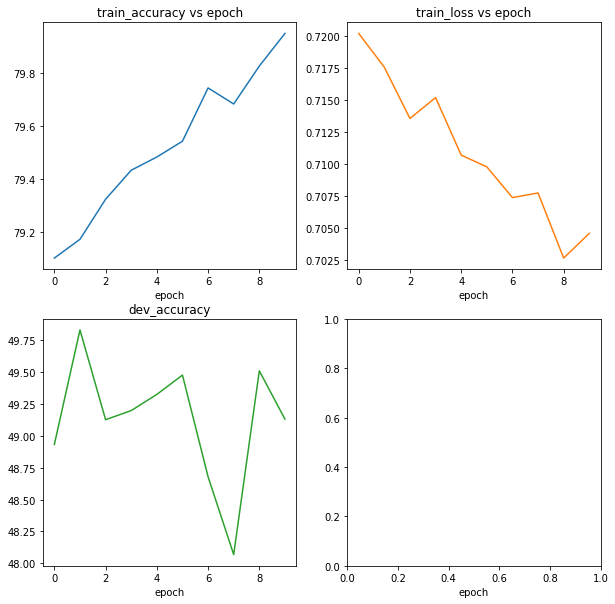

In [59]:
print('n_layers=1 and batch_size=16')
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].plot(mesh, train_dev[0])
axs[0, 0].set_title('train_accuracy vs epoch')
axs[0, 1].plot(mesh, train_dev[1], 'tab:orange')
axs[0, 1].set_title('train_loss vs epoch')
axs[1, 0].plot(mesh, train_dev[2], 'tab:green')
axs[1, 0].set_title('dev_accuracy')

for ax in axs.flat:
    ax.set(xlabel='epoch')

In [60]:
# changing the n_layers
# n_layers = 1 batch_size = 32
train_dev = tunning(batch_size=32)

Training begins ...

Epoch: 0, Training loss: 0.70, Accuracy: 79.88, Time elapsed: 71.43 seconds
Dev Accuracy: 48.65, Time elapsed: 2.02 seconds
Epoch: 1, Training loss: 0.70, Accuracy: 80.02, Time elapsed: 71.49 seconds
Dev Accuracy: 47.72, Time elapsed: 1.97 seconds
Epoch: 2, Training loss: 0.70, Accuracy: 80.02, Time elapsed: 71.06 seconds
Dev Accuracy: 48.91, Time elapsed: 2.06 seconds
Epoch: 3, Training loss: 0.70, Accuracy: 80.20, Time elapsed: 70.92 seconds
Dev Accuracy: 48.98, Time elapsed: 2.01 seconds
Epoch: 4, Training loss: 0.70, Accuracy: 80.23, Time elapsed: 70.93 seconds
Dev Accuracy: 49.09, Time elapsed: 1.99 seconds
Epoch: 5, Training loss: 0.69, Accuracy: 80.28, Time elapsed: 71.13 seconds
Dev Accuracy: 47.61, Time elapsed: 1.98 seconds
Epoch: 6, Training loss: 0.70, Accuracy: 80.32, Time elapsed: 71.06 seconds
Dev Accuracy: 49.31, Time elapsed: 1.97 seconds
Epoch: 7, Training loss: 0.70, Accuracy: 80.38, Time elapsed: 70.95 seconds
Dev Accuracy: 49.14, Time elapsed: 

n_layers=1 and batch_size=32


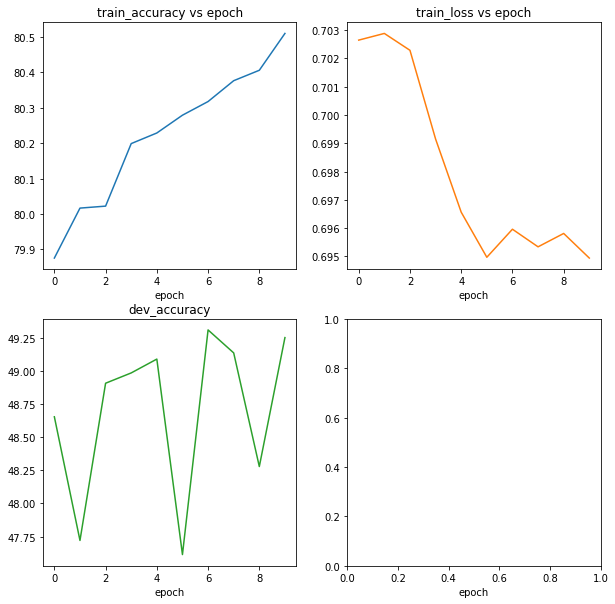

In [61]:
print('n_layers=1 and batch_size=32')
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].plot(mesh, train_dev[0])
axs[0, 0].set_title('train_accuracy vs epoch')
axs[0, 1].plot(mesh, train_dev[1], 'tab:orange')
axs[0, 1].set_title('train_loss vs epoch')
axs[1, 0].plot(mesh, train_dev[2], 'tab:green')
axs[1, 0].set_title('dev_accuracy')

for ax in axs.flat:
    ax.set(xlabel='epoch')

In [63]:
# changing the n_layers
# n_layers = 1 batch_size = 4
train_dev = tunning(batch_size=4)

Training begins ...

Epoch: 0, Training loss: 0.70, Accuracy: 80.53, Time elapsed: 72.33 seconds
Dev Accuracy: 48.32, Time elapsed: 2.03 seconds
Epoch: 1, Training loss: 0.70, Accuracy: 80.53, Time elapsed: 72.94 seconds
Dev Accuracy: 48.39, Time elapsed: 2.04 seconds
Epoch: 2, Training loss: 0.69, Accuracy: 80.53, Time elapsed: 72.63 seconds
Dev Accuracy: 46.97, Time elapsed: 2.00 seconds
Epoch: 3, Training loss: 0.69, Accuracy: 80.63, Time elapsed: 72.72 seconds
Dev Accuracy: 47.57, Time elapsed: 2.04 seconds
Epoch: 4, Training loss: 0.69, Accuracy: 80.71, Time elapsed: 72.76 seconds
Dev Accuracy: 47.88, Time elapsed: 2.05 seconds
Epoch: 5, Training loss: 0.69, Accuracy: 80.83, Time elapsed: 72.49 seconds
Dev Accuracy: 48.32, Time elapsed: 2.06 seconds
Epoch: 6, Training loss: 0.69, Accuracy: 80.71, Time elapsed: 72.63 seconds
Dev Accuracy: 47.21, Time elapsed: 2.00 seconds
Epoch: 7, Training loss: 0.69, Accuracy: 80.87, Time elapsed: 72.29 seconds
Dev Accuracy: 48.16, Time elapsed: 

n_layers=1 and batch_size=4


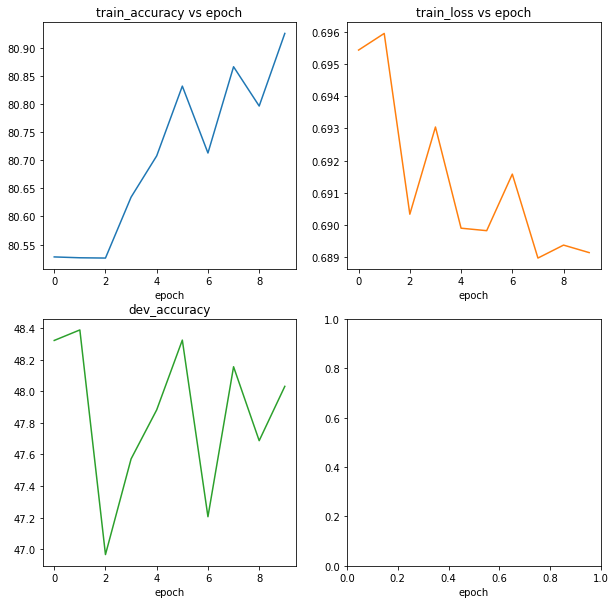

In [64]:
print('n_layers=1 and batch_size=4')
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].plot(mesh, train_dev[0])
axs[0, 0].set_title('train_accuracy vs epoch')
axs[0, 1].plot(mesh, train_dev[1], 'tab:orange')
axs[0, 1].set_title('train_loss vs epoch')
axs[1, 0].plot(mesh, train_dev[2], 'tab:green')
axs[1, 0].set_title('dev_accuracy')

for ax in axs.flat:
    ax.set(xlabel='epoch')

Save log-emission probabilities using the best model saved

In [26]:
def get_log_emission(utt_to_frames_dict, features, prior, temp_parameter, best_model_path):
    """
    Save posteriors using the trained model
    """
    classifier_eval = torch.load(best_model_path)
    classifier_eval.eval()
    log_emission = []
    n_iter = 0
    for utt_idx in range(len(utt_to_frames_dict)):
        frame_id = utt_to_frames_dict[utt_idx]
        log_emission_utt = []
        for i in range(0, len(frame_id), batch_size):
            idx = frame_id[i:i+batch_size]
            Xs = torch.tensor(itemgetter(*idx)(features), dtype=torch.float32).to(device)
            log_pred_Ys = F.log_softmax(classifier_eval(Xs), dim=1).cpu().data.numpy()
            log_emission_utt.append(log_pred_Ys  - temp_parameter*np.log(prior))
        log_emission_utt = np.concatenate(log_emission_utt, axis=0)
        log_emission.append(log_emission_utt)

    return log_emission

In [31]:
temp_parameter = out_cfg["temp_parameter"]
print("Saving log emissions for temperature %.1f ...\n" % (temp_parameter))
prior = data_ldr.get_prior()
train_log_emission =  get_log_emission(train_utt_to_frames, train_features, prior, temp_parameter, save_model_fn)
dev_log_emission = get_log_emission(dev_utt_to_frames, dev_features, prior, temp_parameter, save_model_fn)
test_log_emission = get_log_emission(test_utt_to_frames, test_features, prior, temp_parameter, save_model_fn)
log_emission_dict = {'Ytrain': train_log_emission, 'Ydev': dev_log_emission, 'Ytest': test_log_emission}
np.savez_compressed(os.path.join('hybrid/data/log_emission/log_emission_'+str(temp_parameter)+'.npz'), **log_emission_dict)


Saving log emissions for temperature 1.0 ...



/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


In [33]:
temp_parameter = 0.0
print("Saving log emissions for temperature %.1f ...\n" % (temp_parameter))
prior = data_ldr.get_prior()
train_log_emission =  get_log_emission(train_utt_to_frames, train_features, prior, temp_parameter, save_model_fn)
dev_log_emission = get_log_emission(dev_utt_to_frames, dev_features, prior, temp_parameter, save_model_fn)
test_log_emission = get_log_emission(test_utt_to_frames, test_features, prior, temp_parameter, save_model_fn)
log_emission_dict = {'Ytrain': train_log_emission, 'Ydev': dev_log_emission, 'Ytest': test_log_emission}
np.savez_compressed(os.path.join('hybrid/data/log_emission/log_emission_'+str(temp_parameter)+'.npz'), **log_emission_dict)

Saving log emissions for temperature 0.0 ...



/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


## HMM inference using the posterior from neural network

In [35]:
data_multiple_digit = np.load("hybrid/data/mfccs/mfccs_multiple.npz", allow_pickle=True)

with open("hybrid/hmm/models/multiple_digit_model.pkl", "rb") as f:
    full_model_trained = pkl.load(f)

log_emission_1 = np.load('hybrid/data/log_emission/log_emission_1.0.npz', allow_pickle=True)
log_emission_0 = np.load('hybrid/data/log_emission/log_emission_0.0.npz', allow_pickle=True)
    
def get_test_wer(model, posterior=None):
    test_wer = model.test(data_multiple_digit["Xtest"], data_multiple_digit["Ytest"], posterior)
    print("{:.2f}% TEST WER".format(test_wer * 100.))

print('Baseline performance of the trained model')
get_test_wer(full_model_trained)

print('Performance of the trained model with normalized emission probabilities')
get_test_wer(full_model_trained, log_emission_1["Ytest"])

print('Performance of the trained model with unnormalized emission probabilities')
get_test_wer(full_model_trained, log_emission_0["Ytest"])

Baseline performance of the trained model
24.55% TEST WER
Performance of the trained model with normalized emission probabilities
21.82% TEST WER
Performance of the trained model with unnormalized emission probabilities
17.27% TEST WER
